The Error in Fitting Parameters (Parameter Estimation) 
==============================

Plus: Propagation of Error
=============

We've been using curve_fit to estimate the parameters of various models (the $\beta$ of an NPN bipolar junction transistor, the value of $\eta$ for an LED, and so on). In these cases we've been estimating the uncertainty in the parameters by looking at the diagonal elements of the covariance matrix (returned as the second result of the `curve_fit` function call). You may recognize code like this from project 1:

    popt, pcov = curve_fit(fitExp, data.time.values, data.voltage.values, sigma=sigma)  # do the fit

    A=popt[0]          # get the slope
    tau=popt[1]          # get the intercept

    dA = sqrt(pcov[0,0]) # uncertainty in the slope
    dTau = sqrt(pcov[1,1]) # uncertainty in the intercept
    
This method essentially assumes that the variables (A and tau) are independent and this works pretty well in many simple situations. However there is a way to achieve the same result using monto-carlo simluation that is much more robust in situations where the analytical (covariance) approach would fail. The idea is to characterize the data you have statistically. Then use a monte-carlo approach to fabricate statistally similar data to data you've collected using the same underlying model. Any non-trival interactions between the measurable quantities will also be present in the fabricated data (this is where the trouble with the cavariance matrix approach usually arises). Then you can run `curve_fit` on both the *real* and *fabricated* data. The idea is to use the variabliity in the fit parameters over the fabricated data to estimate the *uncertainty* in the parameters for the *real* data. Confused? No worries! Let's work this out with an example.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd                    # pandas is the "python data analysis package"
import os                              # operating system services
from scipy.optimize import curve_fit   # non-linear curve fitting

## Example: Propagation of Error

Suppose we want to measure the variation of gravity with altitude. We have a theory that gravity gets weaker as you go up higher above sea level. As an approximation we can model this as:

$$ g(y) = g_0 - a y $$

Where $g_0$ is $9.8\ {\rm m/s^2}$ and $a$ is a proportionality constant that indicates how much weaker gravity gets per meter above sea level. How to proceed? Suppose we measure $g$ at a bunch of different $y$ values and try to fit this to a curve. But wait, there's more! We don't have a "$g$ meter", we only have a ruler and a stop watch. Dang! We need to do an experiment at each value of $y$ to estimate $g(y)$ and then use that data to do the fit. OK, so onward!

How to measure "g" with a meter stick and a stopwatch.

Let's drop a ball from a height of 2m and measure how long it takes to hit the ground. According to the basic kinematics you learned in PHYS 153 that should be:

$$ h = 0.5 g t^2 $$

so

$$ t = \sqrt{\frac{2h}{g}} $$

If you're located at a place where $g=9.8\,{\rm N/kg}$ that would be:

$$ t = \sqrt{\frac{2 \cdot 2{\rm m}}{9.8\,{\rm N/kg}}} \approx 0.639\,{\rm sec}$$

Suppose we measured the time for 10 drops and get a mean of 0.64 sec with a standard error (of the mean) of 0.02 sec. Suppose further that we measure the height to within 0.5 cm. With what accuracy do we know $g$?

This problem is called "error propagation". For a single variable you'd use the slope of the functional relationship between output (g) and input (t) to find the relationahip. So, let's look at that.

$$ g = \frac{2h}{t^2} $$

so in the neighborhood of $r=0.64\,{\rm sec}$ that's:

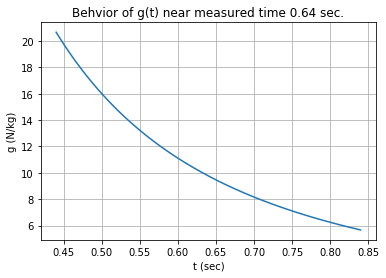

In [2]:
t=np.linspace(0.64-.2, 0.64+0.2, 100)
h=2.0

def g(t,h):
    return 2*h/t**2

pl.plot(t, g(t,h))
pl.title("Behvior of g(t) near measured time 0.64 sec.")
pl.xlabel("t (sec)")
pl.ylabel("g (N/kg)")
pl.grid()


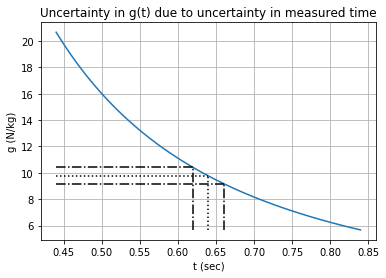

In [3]:
pl.title("Uncertainty in g(t) due to uncertainty in measured time")
pl.xlabel("t (sec)")
pl.ylabel("g (N/kg)")
pl.plot(t, g(t,h))

pl.plot((0.64-0.02,0.64-0.02), (g(t[-1],h),g(0.64-0.02,h)), 'k-.')
pl.plot((0.64+0.02,0.64+0.02), (g(t[-1],h),g(0.64+0.02,h)), 'k-.')
pl.plot((0.64,0.64), (g(t[-1],h),g(0.64,h)), 'k:')
pl.plot((t[0],0.64-0.02), (g(0.64-0.02,h),g(0.64-0.02,h)), 'k-.')
pl.plot((t[0],0.64+0.02), (g(0.64+0.02,h),g(0.64+0.02,h)), 'k-.')
pl.plot((t[0],0.64), (g(0.64,h),g(0.64,h)), 'k:')
pl.grid()




You can see that it's the *slope* of the $g(t)$ function at the time measured that determines the relationship between the uncertainty in $t$ (called $\sigma_t$) and the uncertainty in $g$ (called $\sigma_g$):

$$ \sigma_g = \left|\frac{\partial g}{\partial t}\right|\,\sigma_t $$

In this example the slope of $g(t)$ is:

$$\frac{\partial g}{\partial t} = -\frac{4 h}{t^3} $$

Which makes:

$$ \sigma_g = \left|-\frac{4 h}{t^3}\right|\,\sigma_t $$

But notice that, aside from a sign, the derivative is:

$$\left|\frac{\partial g}{\partial t}\right| = 2\frac{g(t)}{t} $$

In other words:

$$ \frac{\sigma_g}{g} = 2\frac{\sigma_t}{t} $$

Or, in words: Because $t$ is raised to the second power, the fractional error (think percent error) in $g$ is *double* the fractional error of $t$.

This works for *any* power law.

# Combining uncertainty from multiple variables

If you have more than one variable contributing to the uncertainty in a calculation the *combined* uncertainty is calculated as the square root of the sum of the squares of the contribution from each item. Suppose you had a quantity $d$ that was related to quantities $a$, $b$ and $c$ in some arbitrary way so that $d$ was a function of $a$, $b$ and $c$. You could compute the uncertainty in $d$ as:

$$ \sigma_d^2 =  \left ( \frac{\partial d}{\partial a} \sigma_a \right)^2 + \left ( \frac{\partial d}{\partial b} \sigma_b \right)^2 + \left ( \frac{\partial d}{\partial c} \sigma_c \right)^2 $$

This is the general rule, but there are some special cases, like power laws. Suppose, for example, you had a quantity $d$ that was related to quantities $a$, $b$ and $c$ by a power law relationship like:

$$ d = a^n b^m c^p $$

Using this idea you can simplify this situation as:

$$ \left ( \frac{\sigma_d}{d} \right)^2 =  \left ( n \frac{\sigma_a}{a} \right)^2 + \left ( m \frac{\sigma_b}{b} \right)^2 + \left ( p \frac{\sigma_c}{c} \right)^2$$

Note that our gravity example is a power law relationship with $h$ having power 1 and $t$ having power 2.

Let's try this out with our data. Since:

$$ g = \frac{2h}{t^2} = \frac{2\times 2.0\,{\rm m}}{(0.64\,{\rm sec})^2} = 9.765\,{\rm m/sec^2}$$

By the pattern above we have:

$$ \left ( \frac{\sigma_g}{g} \right)^2 =  \left ( 1 \frac{\sigma_h}{h} \right)^2 + \left ( 2 \frac{\sigma_t}{t} \right)^2 $$

We were given above: Suppose we measured the time for 10 drops and get a mean of 0.64 sec with a standard error (of the mean) of 0.02 sec. Suppose further that we measure the height to within 0.5 cm. With what accuracy do we know $g$?

So:

$$ \left ( \frac{\sigma_g}{g} \right)^2 =  \left ( \frac{0.5\,{\rm cm}}{200\,{\rm cm}} \right)^2 + \left ( 2\times \frac{0.02\,{\rm sec}}{0.64\,{\rm sec}} \right)^2  = \left ( \frac{1}{400} \right)^2 + \left (\frac{1}{16} \right)^2 \approx \left (\frac{1}{16} \right)^2 $$

This last approximation is justified because (1/16) is so much larger than (1/400), particularly when combined in quadrature, which means we should expect no better than a fractional error of 6% or so (1/16) and it's all from the uncertainty in the time. Improving the height measurement will do little or nothing to improve the result unless we can drastically reduce the uncertainty in time. To compute the *actual* uncertainty in $g$ we need to multiply:

$$\sigma_g = g \times \left (\frac{1}{16} \right) \approx 0.63\,{\rm m/s^2}$$


Uncertainties in the Parameters
-------------------------------

There are a variety of techniques for estimating the uncertainty in the parameters you compute. The approach we'll take is one of the more "brute force" approaches, but it's pretty robust. We're going to fabricate data that has the same statistics as our original data (do the degree that we know and/or care). Then we'll fit the fabricated data many times (1000 times in this case) and we'll look at the statistics of the fit parameters produced. From this we can tell how well our fit has done at narrowing down the parameters we computed.

Suppose we collect some drop times from a series of heights (see DataFrame below). We can apply the idea of error propagation to find the error in $g$ for each height.


In [4]:
df = pd.DataFrame({'t':[0.639,0.640,0.641,0.640,0.642,0.642], 'y':[0,2000,4000,6000,8000,10000]})
df

,t,y
0,0.639,0
1,0.640,2000
2,0.641,4000
3,0.640,6000
4,0.642,8000
5,0.642,10000


Text(0,0.5,'g (N/kg)')

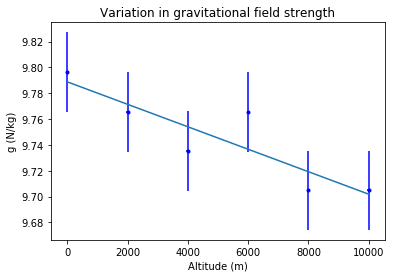

In [5]:
#
# Let's do a linear curve_fit using this data
#

sigma_t = 0.001  # error in time (assume great timing!) ~1ms
sigma_h = 0.001  # tiny error for a 2-meter stick 1mm
sigma_y = 50     # uncertainty in altitude

h_stick = 2.0    # it's a 2-meter stick

tvals = df.t.values  # get the drop time values
yvals = df.y.values  # get the altitude values

g = 2*h_stick/tvals**2  # compute g from the drop times

sigma_g = g*np.sqrt((2*sigma_t/tvals)**2 + (sigma_h/h_stick)**2) # estimate the error in g

def model(y, g0, a):
    return g0 + a*y

par, cov = curve_fit(model, yvals, g)

g0 = par[0]
a = par[1]

gstar = model(yvals, g0, a) # compute model predictions for g, called "gstar"

pl.title("Variation in gravitational field strength")
pl.errorbar(yvals, g, yerr=sigma_g, xerr=sigma_y, fmt='b.')
pl.plot(yvals, gstar)  # plot model predictions
pl.xlabel('Altitude (m)')
pl.ylabel("g (N/kg)")


In [6]:
#
# Now do monte-carlo data fabrication and fit analysis
#

N=1000    # number of samples to take
aList=[]  # keep track of monte-carlo fit parameters
g0List=[]

for i in range(N):
    """
    Generate mc data with the same statistical properties as the real data.
    Repeat the fit for each set, and record the parameters.
    """
    mcG = gstar + sigma_g*np.random.normal(size=len(yvals))
    mcY = yvals + sigma_y*np.random.normal(size=len(yvals))
    par, cov = curve_fit(model, yvals, mcG)
    g0List.append(par[0])
    aList.append(par[1])

#
# Compute the statistics of the mc-results
#

g0arr=np.array(g0List)
aArr=np.array(aList)

g0Avg = g0arr.mean()
aAvg = aArr.mean()
sigg0 = g0arr.std(ddof=1)
sigA = aArr.std(ddof=1)

print("g0= %5.3f +/- %5.3f ( %5.3f, %5.3f )" % (g0, sigg0, g0+sigg0, g0-sigg0 ))
print("a= %5.3e +/- %5.3e ( %5.3e, %5.3e )" % (a, sigA, a+sigA, a-sigA ))


g0= 9.789 +/- 0.023 ( 9.812, 9.766 )
a= -8.693e-06 +/- 3.783e-06 ( -4.910e-06, -1.248e-05 )


g0 average: 9.787973675511342
g0 sigma: 0.022778547976103763


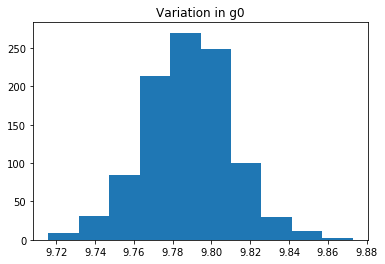

In [7]:
pl.title("Variation in g0")
pl.hist(g0arr) # look at the variation in "g0" values
print("g0 average:", g0Avg)
print("g0 sigma:",sigg0)

a average: -8.640500800675252e-06
a sigma: 3.7832676701102635e-06


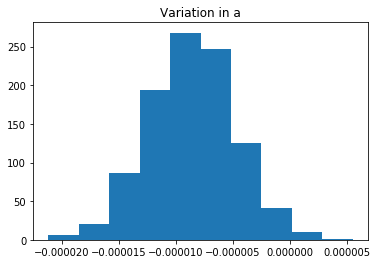

In [8]:
pl.title("Variation in a")
pl.hist(aArr)  # look at the variation in "a" values
print("a average:", aAvg)
print("a sigma:",sigA)

# Exercises

1) Suppose you want to cut out material for a thermal cover for an orbiting satellite. You want to estimate the uncertainty of the area (and hence mass) of the cover based on the precision with whcih you can measure the width and length of the cut. Suppose it's a 1-m x 1-m area with a precision of +/- 0.5 cm. Use the ideas from propagation of uncertainty to estimate the uncertainty in the area.

2) Give the following data:

    x: 1,2,3,4,5,6    
    y: 3,5,7,9,11,13
    
  Assume that the uncertainty in the x values is +/- 0.1 and the y values is 0.2. Use MC estimation to get the slope and intercept along with estimates of the uncertainty in slope and intercept.
  
    
    
